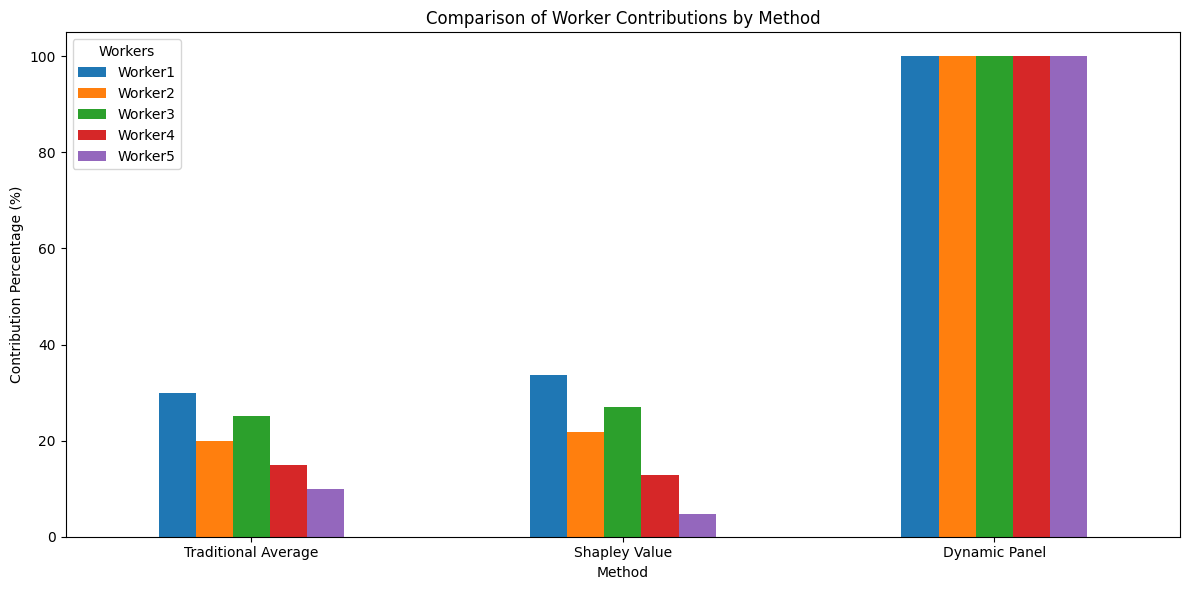


Comparison Table:
                         Worker1     Worker2     Worker3     Worker4  \
Traditional Average   29.950619   19.919221   25.104773   15.029030   
Shapley Value         33.682224   21.870172   27.023759   12.784101   
Dynamic Panel        100.000000  100.000000  100.000000  100.000000   

                        Worker5  
Traditional Average    9.996358  
Shapley Value          4.639745  
Dynamic Panel        100.000000  


In [1]:
"""
Evaluate and Compare Worker Contributions
Description: Compare Traditional Average Contribution, Shapley Values, and Dynamic Panel Data Models.
Requirements: Install `shap`, `pandas`, `matplotlib`, `linearmodels`, `sklearn` via pip.
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

def load_data(file_path):
    """
    Load synthetic worker productivity dataset.
    """
    return pd.read_csv(file_path, index_col=0, parse_dates=True)

def traditional_average_contribution(data):
    """
    Calculate worker contributions using the traditional average method.
    """
    total_avg = data.mean().sum()  # Total average productivity
    contributions = (data.mean() / total_avg) * 100  # Percentage contribution
    return contributions

def shapley_value_contribution(data):
    """
    Calculate worker contributions using Shapley Value Analysis.
    """
    X = data  # Features: worker productivity
    y = data.sum(axis=1)  # Target: total productivity

    # Train Random Forest model
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    # Calculate Shapley values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    contributions = np.abs(shap_values).mean(axis=0)  # Average absolute Shapley values
    total_contribution = contributions / contributions.sum() * 100  # Percentage
    return pd.Series(total_contribution, index=X.columns)

def dynamic_panel_contribution(data):
    """
    Calculate worker contributions using Dynamic Panel Data Models.
    """
    # Convert to panel format
    panel_data = data.stack().reset_index()
    panel_data.columns = ['Date', 'Worker', 'Productivity']
    panel_data.set_index(['Worker', 'Date'], inplace=True)

    # Add lagged productivity
    panel_data['LaggedProductivity'] = panel_data.groupby(level=0)['Productivity'].shift(1)
    panel_data.dropna(inplace=True)

    # Fit Panel OLS model
    model = PanelOLS.from_formula('Productivity ~ LaggedProductivity + EntityEffects', data=panel_data)
    results = model.fit()

    # Extract worker contributions
    coefficients = results.params['LaggedProductivity']  # Coefficients for lagged contributions
    contributions = coefficients / coefficients.sum() * 100  # Percentage
    return pd.Series(contributions, index=panel_data.index.get_level_values(0).unique())

def visualize_contributions(traditional, shapley, panel):
    """
    Visualize worker contributions from different methods.
    """
    # Combine contributions
    comparison = pd.DataFrame({
        "Traditional Average": traditional,
        "Shapley Value": shapley,
        "Dynamic Panel": panel
    }).T

    # Plot
    comparison.plot(kind='bar', figsize=(12, 6))
    plt.title("Comparison of Worker Contributions by Method")
    plt.ylabel("Contribution Percentage (%)")
    plt.xlabel("Method")
    plt.xticks(rotation=0)
    plt.legend(title="Workers")
    plt.tight_layout()
    plt.show()

    return comparison

if __name__ == "__main__":
    # Load synthetic dataset
    data = load_data("synthetic_validation_dataset.csv")

    # Calculate contributions
    traditional = traditional_average_contribution(data)
    shapley = shapley_value_contribution(data)
    panel = dynamic_panel_contribution(data)

    # Visualize and compare contributions
    results = visualize_contributions(traditional, shapley, panel)
    print("\nComparison Table:\n", results)
